In [1]:
# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import load_model
from matplotlib import pyplot
import preprocess
import tensorflow as tf

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x30
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load('img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=64):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
#     bat_per_epo = dataset.shape[0] // n_batch
    half_batch = n_batch // 2
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        t=0
        for data,index in dataset:
            if len(data) !=n_batch//2:
                g_model.save('generator_model_2.h5')
                continue
            # get randomly selected 'real' samples
            X_real = (data-127.5)/255
            y_real = ones((half_batch, 1))
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1,  d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
#         if (i+1) % 10 == 0:
#             summarize_performance(i, g_model, d_model, dataset, latent_dim)



In [3]:
# size of the latent space
latent_dim = 200
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# g_model = load_model('generator_model_2.h5')
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = preprocess.load_images(batch_size = 64)

Found 202599 files belonging to 4 classes.


In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, d1=0.244, d2=0.185 g=2.424
>1, d1=0.349, d2=0.377 g=2.155
>1, d1=0.425, d2=0.386 g=2.248
>1, d1=0.357, d2=0.290 g=2.431
>1, d1=0.328, d2=0.208 g=2.239
>1, d1=0.416, d2=0.366 g=2.034
>1, d1=0.438, d2=0.405 g=2.411
>1, d1=0.409, d2=0.267 g=2.349
>1, d1=0.417, d2=0.301 g=2.322
>1, d1=0.470, d2=0.290 g=2.303
>1, d1=0.611, d2=0.267 g=2.014
>1, d1=0.340, d2=0.405 g=2.063
>1, d1=0.250, d2=0.300 g=2.319
>1, d1=0.403, d2=0.266 g=2.202
>1, d1=0.322, d2=0.297 g=2.301
>1, d1=0.435, d2=0.387 g=2.311
>1, d1=0.525, d2=0.247 g=2.266
>1, d1=0.290, d2=0.334 g=2.307
>1, d1=0.317, d2=0.210 g=2.456
>1, d1=0.282, d2=0.227 g=2.172
>1, d1=0.292, d2=0.254 g=2.447
>1, d1=0.471, d2=0.354 g=2.323
>1, d1=0.368, d2=0.322 g=2.225
>1, d1=0.252, d2=0.303 g=2.558
>1, d1=0.322, d2=0.261 g=2.387
>1, d1=0.293, d2=0.291 g=2.219
>1, d1=0.542, d2=0.325 g=2.125
>1, d1=0.392, d2=0.409 g=2.464
>1, d1=0.336, d2=0.197 g=2.365
>1, d1=0.484, d2=0.264 g=2.657
>1, d1=0.449, d2=0.242 g=2.436
>1, d1=0.522, d2=0.416 g=2.283
>1, d1=0

>1, d1=0.429, d2=0.254 g=2.539
>1, d1=0.437, d2=0.314 g=2.217
>1, d1=0.335, d2=0.260 g=2.285
>1, d1=0.403, d2=0.353 g=2.498
>1, d1=0.315, d2=0.160 g=2.314
>1, d1=0.440, d2=0.411 g=2.356
>1, d1=0.437, d2=0.345 g=2.310
>1, d1=0.384, d2=0.352 g=2.433
>1, d1=0.277, d2=0.242 g=2.561
>1, d1=0.353, d2=0.284 g=2.431
>1, d1=0.449, d2=0.311 g=2.461
>1, d1=0.416, d2=0.272 g=2.536
>1, d1=0.637, d2=0.243 g=2.192
>1, d1=0.356, d2=0.260 g=2.109
>1, d1=0.289, d2=0.293 g=2.252
>1, d1=0.371, d2=0.228 g=2.405
>1, d1=0.288, d2=0.283 g=2.383
>1, d1=0.345, d2=0.198 g=2.502
>1, d1=0.223, d2=0.263 g=2.506
>1, d1=0.193, d2=0.291 g=2.728
>1, d1=0.398, d2=0.254 g=2.713
>1, d1=0.604, d2=0.235 g=2.308
>1, d1=0.244, d2=0.318 g=2.242
>1, d1=0.324, d2=0.339 g=2.510
>1, d1=0.508, d2=0.445 g=2.530
>1, d1=0.388, d2=0.197 g=2.168
>1, d1=0.252, d2=0.236 g=2.499
>1, d1=0.405, d2=0.214 g=2.190
>1, d1=0.407, d2=0.544 g=2.249
>1, d1=0.427, d2=0.422 g=2.508
>1, d1=0.484, d2=0.201 g=2.445
>1, d1=0.536, d2=0.346 g=2.123
>1, d1=0

>1, d1=0.342, d2=0.363 g=2.496
>1, d1=0.398, d2=0.320 g=2.611
>1, d1=0.457, d2=0.225 g=2.424
>1, d1=0.495, d2=0.364 g=2.478
>1, d1=0.504, d2=0.393 g=2.536
>1, d1=0.309, d2=0.298 g=2.747
>1, d1=0.466, d2=0.274 g=2.319
>1, d1=0.318, d2=0.454 g=2.521
>1, d1=0.525, d2=0.177 g=2.340
>1, d1=0.342, d2=0.364 g=2.608
>1, d1=0.421, d2=0.234 g=2.510
>1, d1=0.502, d2=0.210 g=2.396
>1, d1=0.298, d2=0.298 g=2.310
>1, d1=0.294, d2=0.295 g=2.476
>1, d1=0.391, d2=0.349 g=2.408
>1, d1=0.528, d2=0.280 g=2.484
>1, d1=0.292, d2=0.201 g=2.425
>1, d1=0.449, d2=0.423 g=2.636
>1, d1=0.543, d2=0.209 g=2.405
>1, d1=0.404, d2=0.216 g=2.102
>1, d1=0.369, d2=0.426 g=2.209
>1, d1=0.401, d2=0.248 g=2.393
>1, d1=0.300, d2=0.318 g=2.365
>1, d1=0.393, d2=0.231 g=2.468
>1, d1=0.270, d2=0.274 g=2.545
>1, d1=0.471, d2=0.347 g=2.562
>1, d1=0.304, d2=0.226 g=2.916
>1, d1=0.615, d2=0.299 g=2.236
>1, d1=0.279, d2=0.376 g=2.552
>1, d1=0.368, d2=0.332 g=2.490
>1, d1=0.272, d2=0.187 g=2.765
>1, d1=0.326, d2=0.242 g=2.307
>1, d1=0

>1, d1=0.489, d2=0.451 g=2.335
>1, d1=0.289, d2=0.320 g=3.105
>1, d1=0.577, d2=0.141 g=2.523
>1, d1=0.406, d2=0.412 g=2.549
>1, d1=0.399, d2=0.261 g=2.486
>1, d1=0.337, d2=0.244 g=2.354
>1, d1=0.451, d2=0.307 g=2.358
>1, d1=0.327, d2=0.372 g=2.453
>1, d1=0.345, d2=0.250 g=2.247
>1, d1=0.292, d2=0.207 g=2.496
>1, d1=0.479, d2=0.360 g=2.144
>1, d1=0.327, d2=0.261 g=2.593
>1, d1=0.356, d2=0.251 g=2.633
>1, d1=0.326, d2=0.357 g=2.899
>1, d1=0.418, d2=0.132 g=2.557
>1, d1=0.345, d2=0.313 g=2.478
>1, d1=0.321, d2=0.160 g=2.658
>1, d1=0.372, d2=0.301 g=2.514
>1, d1=0.387, d2=0.239 g=2.404
>1, d1=0.219, d2=0.262 g=2.692
>1, d1=0.255, d2=0.193 g=2.900
>1, d1=0.402, d2=0.228 g=2.532
>1, d1=0.470, d2=0.557 g=2.401
>1, d1=0.671, d2=0.348 g=2.462
>1, d1=0.461, d2=0.305 g=2.509
>1, d1=0.409, d2=0.290 g=2.220
>1, d1=0.482, d2=0.362 g=2.377
>1, d1=0.398, d2=0.261 g=2.304
>1, d1=0.235, d2=0.315 g=2.559
>1, d1=0.489, d2=0.199 g=2.371
>1, d1=0.252, d2=0.277 g=2.345
>1, d1=0.303, d2=0.231 g=2.448
>1, d1=0

>1, d1=0.229, d2=0.181 g=2.299
>1, d1=0.273, d2=0.308 g=2.548
>1, d1=0.354, d2=0.252 g=2.402
>1, d1=0.364, d2=0.352 g=2.458
>1, d1=0.522, d2=0.270 g=2.383
>1, d1=0.225, d2=0.297 g=2.693
>1, d1=0.291, d2=0.177 g=2.841
>1, d1=0.397, d2=0.291 g=2.628
>1, d1=0.326, d2=0.194 g=2.841
>1, d1=0.377, d2=0.195 g=2.736
>1, d1=0.295, d2=0.282 g=2.437
>1, d1=0.256, d2=0.211 g=2.352
>1, d1=0.251, d2=0.233 g=2.736
>1, d1=0.372, d2=0.277 g=2.638
>1, d1=0.387, d2=0.407 g=2.905
>1, d1=0.573, d2=0.156 g=2.692
>1, d1=0.267, d2=0.312 g=2.695
>1, d1=0.221, d2=0.213 g=2.808
>1, d1=0.353, d2=0.237 g=2.948
>1, d1=0.283, d2=0.145 g=2.646
>1, d1=0.286, d2=0.461 g=2.729
>1, d1=0.380, d2=0.172 g=2.734
>1, d1=0.448, d2=0.361 g=2.609
>1, d1=0.492, d2=0.424 g=2.682
>1, d1=0.626, d2=0.194 g=2.545
>1, d1=0.486, d2=0.269 g=2.355
>1, d1=0.297, d2=0.339 g=2.600
>1, d1=0.523, d2=0.295 g=2.362
>1, d1=0.280, d2=0.237 g=2.720
>1, d1=0.366, d2=0.237 g=2.607
>1, d1=0.286, d2=0.268 g=2.830
>1, d1=0.362, d2=0.248 g=2.998
>1, d1=0

>1, d1=0.511, d2=0.301 g=2.104
>1, d1=0.322, d2=0.337 g=2.152
>1, d1=0.415, d2=0.274 g=2.298
>1, d1=0.418, d2=0.410 g=2.293
>1, d1=0.304, d2=0.182 g=2.478
>1, d1=0.334, d2=0.204 g=2.506
>1, d1=0.351, d2=0.266 g=2.520
>1, d1=0.434, d2=0.198 g=2.335
>1, d1=0.218, d2=0.395 g=2.733
>1, d1=0.504, d2=0.249 g=2.488
>1, d1=0.330, d2=0.467 g=2.634
>1, d1=0.205, d2=0.142 g=2.851
>1, d1=0.535, d2=0.354 g=2.679
>1, d1=0.421, d2=0.227 g=2.553
>1, d1=0.423, d2=0.210 g=2.061
>1, d1=0.245, d2=0.336 g=2.552
>1, d1=0.416, d2=0.214 g=2.461
>1, d1=0.387, d2=0.291 g=2.329
>1, d1=0.301, d2=0.263 g=2.579
>1, d1=0.421, d2=0.273 g=2.354
>1, d1=0.477, d2=0.302 g=2.489
>1, d1=0.319, d2=0.280 g=2.370
>1, d1=0.395, d2=0.356 g=2.516
>1, d1=0.380, d2=0.279 g=2.503
>1, d1=0.412, d2=0.318 g=2.312
>1, d1=0.346, d2=0.378 g=2.433
>1, d1=0.263, d2=0.281 g=2.487
>1, d1=0.435, d2=0.267 g=2.402
>1, d1=0.504, d2=0.221 g=2.382
>1, d1=0.282, d2=0.399 g=2.566
>1, d1=0.296, d2=0.201 g=2.625
>1, d1=0.393, d2=0.376 g=2.615
>1, d1=0

In [172]:
filename = 'generator_model_2.h5'
g_model.save(filename)
d_model.save('discriminator_model_2.h5')

In [208]:
g, bnn = generate_fake_samples(g_model, latent_dim, 1)

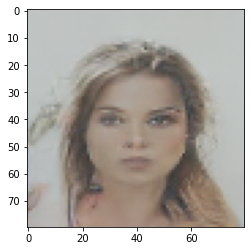

In [209]:
pyplot.imshow(tf.constant((g[0]+1)/2))